In [1]:
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import numpy as np
import utility as ut
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
from scipy.signal import welch
import seaborn as sns
import oneshot as sm
import rfm, skipRFM, deepSkip, localRFM, localDeepRFM
# import parallel_euler as arch1
import torch
from torch import nn
import glob, shutil
import config as cf
from matplotlib.text import Text
from matplotlib import ticker
from matplotlib.collections import PolyCollection
from scipy.stats import ks_2samp 
import count_params as cp
import wasserstein as ws

L = 200
dynamical_system = f'KS-{L}'
root = f'../data/{dynamical_system}'
config = 'config_1' 
summary = ut.summary(dynamical_system)[config]
kwargs = {200:{'error_threshold': 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.094},\
          22:{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.043},\
          12:{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.003},\
         '13_5':{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.059},\
         '200-001':{'error_threshold': 0.25, 'dt': 0.001, 'Lyapunov_time': 1/0.094},\
         '200-01':{'error_threshold': 0.25, 'dt': 0.01, 'Lyapunov_time': 1/0.094},}
clrs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

summary

{'LocalSkipN_8_1': {(15000, 1, 8, 1): [4.2958,
   0.8441757497066505,
   4.40625,
   2.0445,
   6.3685,
   4.240000000000001e-05,
   3.7782645416259766,
   495000]},
 'LocalDeepSkipN_8_1': {(15000, 2, 8, 1): [5.041173,
   0.8519007555846698,
   5.1465,
   2.6085,
   7.708,
   2e-05,
   7.909782587051391,
   1230000]},
 'LocalRFMN_8_1': {(15000, 1, 8, 1): [4.310792999999999,
   0.8627200550803694,
   4.3945,
   2.0445,
   6.3685,
   4.240000000000001e-05,
   3.785320994377136,
   495000]},
 'LocalDeepRFM_4_2': {},
 'LocalDeepRFM_8_1': {(8192, 2, 8, 1): [4.0182649999999995,
   1.2811086433191268,
   4.2065,
   0.47,
   6.8385,
   4.599999999999999e-06,
   2.0723123483657835,
   671744],
  (8192, 3, 8, 1): [4.5417510000000005,
   0.9572833961267687,
   4.5825,
   1.0105,
   7.0735,
   3.52e-05,
   3.0827652449607847,
   1007616],
  (13308, 5, 8, 1): [4.634341,
   0.9607374584907651,
   4.7235,
   1.8565,
   6.956,
   9.550000000000002e-05,
   14.536895933628083,
   2728140],
  (15000, 2, 

**Find optimal localization**

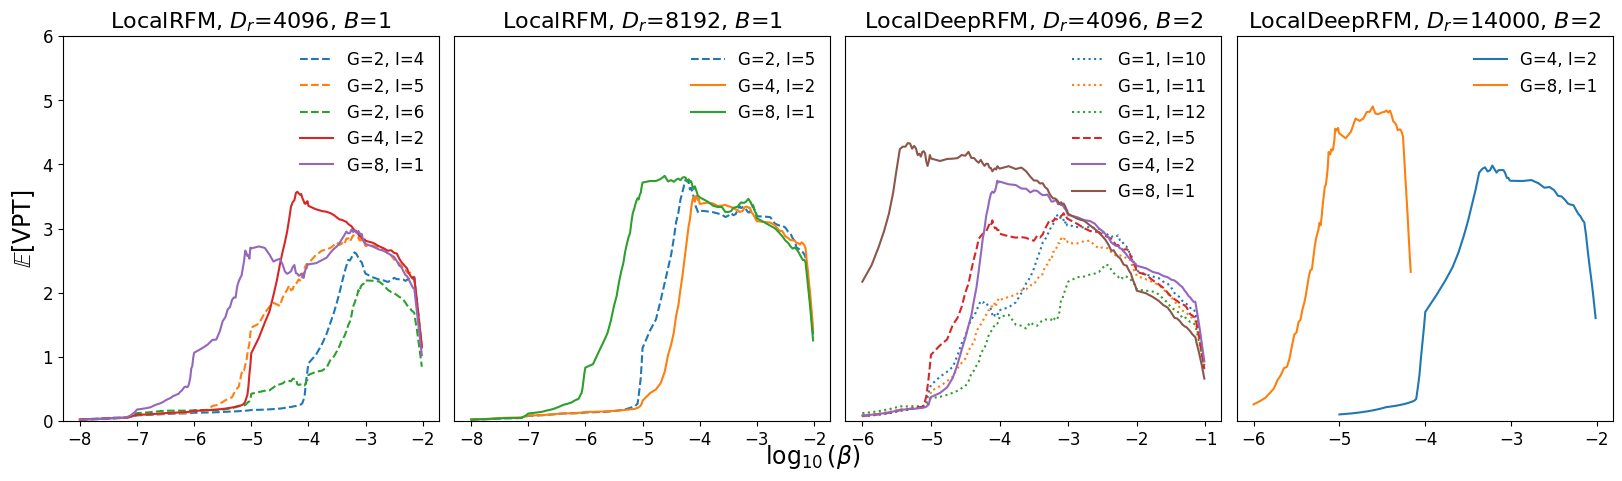

In [107]:
configs = ['config_local', 'config_local', 'config_local', 'config_1']
architectures = ['LocalRFM', 'LocalRFM', 'LocalDeepRFM', 'LocalDeepRFM']
GI = [[2, 4], [2, 5], [2, 6], [4, 2], [8, 1]]
GI0 = [[2, 5], [4, 2], [8, 1]]
GI1 = [[1, 10], [1, 11], [1, 12], [2, 5], [4, 2], [8, 1]]
GI2 = [[4, 2], [8, 1]]
localizations = [GI, GI0, GI1, GI2]
D_rB = [[4096, 1]] * len(GI)
D_rB0 = [[8192, 1]] * len(GI0)
D_rB1 = [[4096, 2]] * len(GI1)
D_rB2 = [[14000, 2]] * len(GI2)
structures = [D_rB, D_rB0, D_rB1, D_rB2]
markers = ['x', 'v']
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax1 = fig.add_subplot(142)
ax2 = fig.add_subplot(143)
ax3 = fig.add_subplot(144)
axs = [ax, ax1, ax2, ax3]
smoothing_window = 15
for i, architecture in enumerate(architectures):
    for j, localization in enumerate(localizations[i]):
        G, I = localization
        D_r, B = structures[i][j]
        if G==2:
            linestyle = 'dashed'
        elif G==8:
            linestyle = 'solid'
        elif G==1:
            linestyle = 'dotted'
        elif G==4:
            linestyle = 'solid'
        data = pd.read_csv(f'{root}/{configs[i]}/{architecture}_{G}_{I}/beta/beta_D_r-{D_r}_B-{B}.csv')
        x, y = data['beta'], data['tau_f_nmse_mean']
        y = ut.smooth(y, smoothing_window)
        axs[i].plot(np.log10(x), y, label=f'G={G}, I={I}', linestyle=linestyle)#, s=20, marker=markers[i])
    axs[i].set_title(fr"{architecture}, $D_r$={D_r}, $B$={B}", fontsize=16)
    axs[i].legend(frameon=False, fontsize=12)
    axs[i].set_ylim((0, 6))
    if i==0:
        axs[i].set_ylabel(r'$\mathbb{E}[{\rm VPT}]$', fontsize=17)
    else:
        axs[i].set_yticks([])
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].tick_params(axis='both', which='minor', labelsize=12)
fig.supxlabel(r'$\log_{10}(\beta)$', fontsize=17)
fig.subplots_adjust(wspace=0.04)
plt.savefig(f'../data/plots/final/{dynamical_system}-localization-schemes.pdf', bbox_inches='tight', dpi=300)

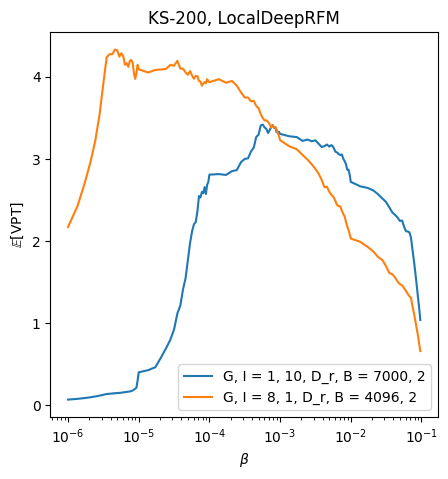

In [10]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

data = pd.read_csv(f'{root}/config_local/LocalDeepRFM_{1}_{10}/beta/beta_D_r-{7000}_B-{2}.csv')
x, y = data['beta'], data['tau_f_nmse_mean']
y = ut.smooth(y, smoothing_window)
ax.semilogx(x, y, label=f'G, I = 1, 10, D_r, B = 7000, 2')#, s=20, marker=markers[i])

data = pd.read_csv(f'{root}/config_local/LocalDeepRFM_{8}_{1}/beta/beta_D_r-{4096}_B-{2}.csv')
x, y = data['beta'], data['tau_f_nmse_mean']
y = ut.smooth(y, smoothing_window)
ax.semilogx(x, y, label=f'G, I = 8, 1, D_r, B = 4096, 2')#, s=20, marker=markers[i])
ax.set_title(r'KS-200, LocalDeepRFM')
ax.legend()
ax.legend()
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\mathbb{E}[{\rm VPT}]$')
plt.savefig(f'../data/plots/{dynamical_system}-loc-equal.png', bbox_inches='tight', dpi=300)

**Violin plot of VPT**

['LocalRFM_8_1', 512, 8192, 1, 8, 1, 270336]
['LocalRFM_8_1', 512, 15000, 1, 8, 1, 495000]
['LocalDeepRFM_8_1', 512, 8192, 2, 8, 1, 671744]
['LocalDeepRFM_8_1', 512, 14000, 2, 8, 1, 1148000]
['LocalDeepRFM_8_1', 512, 15000, 2, 8, 1, 1230000]
['LocalDeepSkip_8_1', 512, 15000, 2, 8, 1, 1230000]
['LocalDeepRFMN_8_1', 512, 15000, 2, 8, 1, 1230000]
['LocalDeepSkipN_8_1', 512, 15000, 2, 8, 1, 1230000]


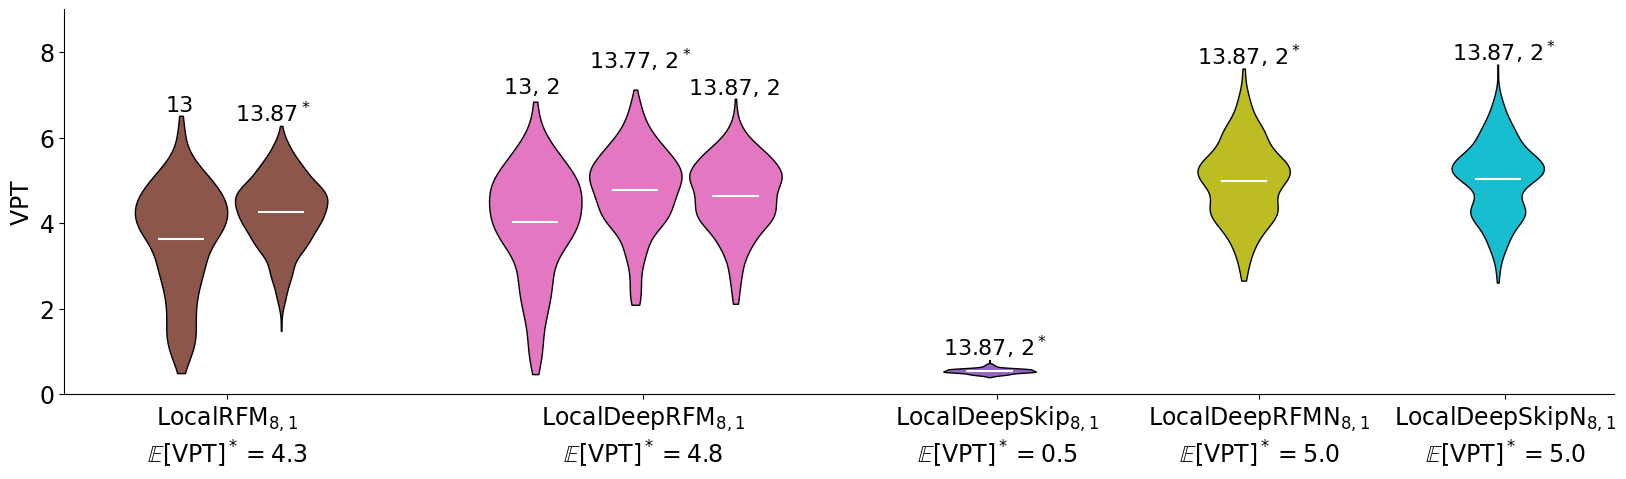

In [44]:
config = 'config_1'
architectures = {'config_1':['LocalRFM_8_1', 'LocalDeepRFM_8_1', 'LocalDeepSkip_8_1', 'LocalDeepRFMN_8_1', 'LocalDeepSkipN_8_1']}
clrs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#9467bd', '#bcbd22', '#17becf'][5:]
colors = {'config_1_s':clrs, 'config_1':clrs}
x_pos = {'config_1_s':[1.5], 'config_1':[0.3, 3, 5.3, 7.0, 8.6]}
x_labels = [r'LocalRFM$_{8,1}$', r'LocalDeepRFM$_{8,1}$', r'LocalDeepSkip$_{8,1}$', r'LocalDeepRFMN$_{8,1}$', r'LocalDeepSkipN$_{8,1}$']
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
smoothing_window = 5
m, n = 0, 0
params = []
best = []
vpts = []
cs = []
positions = []
for i, architecture in enumerate(architectures[config]):
    df_data = {'#params': [], 'vpt': []}
    subfolders = [x for x in glob.glob(f'{root}/{config}/{architecture}/*') if not 'beta' in x]
    subfolders = [x for x in subfolders if os.path.exists(f'{x}/batch_data.csv') and "13308" not in x]
    sizes = [[x[2], x[3]] for x in list(map(ut.get_arch, subfolders))]
    subfolders = [x for _, x in sorted(zip(sizes, subfolders))]
    
    n += len(subfolders)-1 
    best += [np.array(list(summary[architecture].values()))[:, 0].max()]
    for j, subfolder in enumerate(subfolders):
        arch = ut.get_arch(subfolder)
        if arch[3] == 3:
            continue
        if arch[0].startswith('LocalDeepRFMN') and arch[2] == 14000:
            continue
        data = pd.read_csv(f'{subfolder}/batch_data.csv')
        vpt = data['tau_f_nmse']
        vpts.append(vpt)
        p = np.log10(arch[-1])
        df_data['#params'] += [m] * len(vpt)
        df_data['vpt'] += vpt.to_list()
        params += [p]
        if arch[2] == 13308:
            logdr = "13.7"
        elif arch[2] == 14000:
            logdr = "13.77"
        elif arch[2] == 15000:
            logdr = "13.87"
        else:
            logdr = int(np.log2(arch[2]))
        if arch[3] > 1:
            text = r"{}, {}".format(logdr, arch[3])
        else:
            text = r"{}".format(logdr)
        if vpt.mean() == best[-1]:
            text += r'$^*$'
        if arch[0]=='LocalRFM_8_1' and arch[2]==2**13:
            ax.text(m-0.1, vpt.max()+0.1, text, fontsize=16)
        elif arch[0]=='LocalRFM_8_1' and arch[2]==14000:
            ax.text(m, vpt.max()+0.1, text, fontsize=16)
        elif arch[0]=='LocalDeepRFM_8_1' and arch[2]==2**13 and arch[3]==2:
            ax.text(m-0.2, vpt.max()+0.2, text, fontsize=16)
        elif arch[0]=='LocalDeepRFM_8_1' and arch[2]==14000 and arch[3]==2:
            ax.text(m-0.3, vpt.max()+0.5, text, fontsize=16)
        elif arch[0]=='LocalDeepRFM_8_1' and arch[2]==14000 and arch[3]==3:
            ax.text(m-0.4, vpt.max()+0.1, text, fontsize=16)
        elif arch[0]=='LocalDeepRFM_8_1' and arch[2]==15000 and arch[3]==2:
            ax.text(m-0.3, vpt.max()+0.1, text, fontsize=16)
        elif arch[0]=='LocalDeepRFM_8_1' and arch[2]==15000 and arch[3]==3:
            ax.text(m-0.35, vpt.max()+0.2, text, fontsize=16)
        else:
            ax.text(m-0.3, vpt.max()+0.1, text, fontsize=16)
        print(arch)
        positions += [m]
        m += 0.65
        cs.append(colors[config][i])
    if i==1:
        m+=1.0
    elif i==3:
        m+=1.0
    else:
        m+=1.0
    
    df = pd.DataFrame(df_data)
violin_parts = ax.violinplot(vpts, positions=positions, showextrema=False, showmeans=True, side="both", widths=0.6)
for k, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(cs[k])
    pc.set_edgecolor('black')
    pc.set_alpha(1)
violin_parts['cmeans'].set_color('white')

for art in ax.get_children():
    if isinstance(art, PolyCollection):
        art.set_edgecolor('black')
ax.set_xticks(x_pos[config], labels=[x_labels[i] + '\n' + r'$\mathbb{E}[\rm VPT]^*=$' + f'{best[i]:.1f}' for i in range(len(architectures[config]))])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(r'')
ax.set_ylabel(r'${\rm VPT}$', fontsize=17)
ax.set_ylim((0, 9))
ax.tick_params(axis='both', which='major', labelsize=17)
ax.tick_params(axis='both', which='minor', labelsize=17)
plt.savefig(f'../data/plots/final/{dynamical_system}-{config}-vpt-violin.pdf', bbox_inches='tight', dpi=300)

][?**Climate plot**

KeyboardInterrupt: 

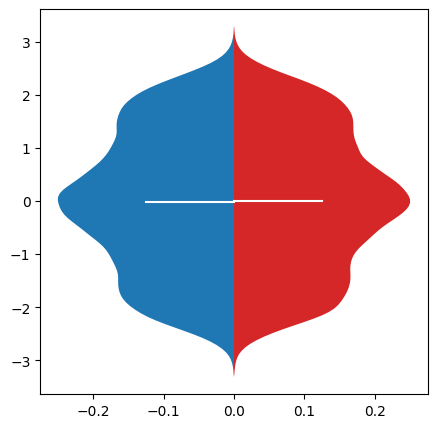

In [188]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
archs = [ 'LocalDeepRFMN', 'LocalDeepSkipN'] #'LocalRFM', 'LocalDeepRFM', 'LocalDeepSkip',
archs_ = ['LocalRFM_8_1', 'LocalDeepRFM_8_1', 'LocalDeepSkip_8_1', 'LocalDeepRFMN_8_1', 'LocalDeepSkipN_8_1'][3:]
x_labels = ['LocalRFM$_{8,1}$', 'LocalDeepRFM$_{8,1}$', 'LocalDeepSkip$_{8,1}$', 'LocalDeepRFMN$_{8,1}$', 'LocalDeepSkipN$_{8,1}$'][3:]
x_pos = [0, 1]
tops = [r'$x_{20}$']
folders = [f'{root}/config_1/attractor' for arch in archs]
idx1 = torch.randperm(512*100000)[:100000].numpy()
idx2 = torch.randperm(512*100000)[:100000].numpy()
reconstruction = [np.load(f'{folders[i]}/{archs[i]}/attractor.npy').flatten()[idx1] for i in range(2)]
original = [np.load(f'{folders[i]}/train.npy').flatten()[idx2] for i in range(2)]
w2_data = pd.read_csv(f'{root}/{dynamical_system}-w2.csv')
for i, arch in enumerate(archs):
    vp_left = ax.violinplot(reconstruction[i], positions=[i], showextrema=False, showmeans=True, side="low")
    vp_right = ax.violinplot(original[i], positions=[i], showextrema=False, showmeans=True, side="high")
    for vp in [vp_left, vp_right]:
        # vp['cmeans'].set_colors('white')
        for k, pc in enumerate(vp['bodies']):
            pc.set_alpha(1.0)
            if vp==vp_left:
                pc.set_facecolor(clrs[0])
                vp['cmeans'].set_colors('white')
            else:
                pc.set_facecolor(clrs[3])
                vp['cmeans'].set_colors('white')
    top = np.max([reconstruction[i].max(), original[i].max()])
    idx1 = torch.randperm(len(original[i]))[:20000]
    idx2 = torch.randperm(len(reconstruction[i]))[:20000]
    # w2 = w2_data[w2_data['architecture']==archs_[i]].iloc[0]["w2"]
    # ax.text(i-0.1, 3.5, rf'{ut.l2_kde(original[i], reconstruction[i], 10000):.1e}', fontsize=14)
    w2 = ws.sinkhorn_div(torch.tensor(original[i])[idx1].reshape(-1, 1), torch.tensor(reconstruction[i])[idx2].reshape(-1, 1))
    ax.text(i-0.1, 3.5, rf'{w2**0.5:.2f}', fontsize=14)
ax.set_ylim((-5, 5))
ax.legend([vp_left['bodies'][0], vp_right['bodies'][0]], ["Surrogate model", "KS"], loc='lower right', fontsize=12)
ax.set_xticks(x_pos, labels=x_labels)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.savefig(f'../data/plots/final/{dynamical_system}-climate.pdf', bbox_inches='tight', dpi=300)

In [ ]:
df1 = pd.read_csv(f'{root}/{dynamical_system}-w2.csv')
df2 = pd.read_csv(f'{root}/{dynamical_system}-condW.csv')
plt.scatter()

**Runtime and model size**

['SkipRFM', 40, 4096, 1, 331776]
['SkipRFM', 40, 8192, 1, 663552]
['SkipRFM', 40, 1024, 1, 82944]
['SkipRFM', 40, 512, 1, 41472]
['SkipRFM', 40, 2048, 1, 165888]
['DeepSkip', 40, 4096, 8, 3964928]
['DeepSkip', 40, 4096, 1, 495616]
['DeepSkip', 40, 4096, 16, 7929856]
['DeepSkip', 40, 4096, 4, 1982464]
['DeepSkip', 40, 4096, 2, 991232]
['LocalSkip_2_2', 40, 4096, 1, 2, 2, 53248]
['LocalSkip_2_2', 40, 8192, 1, 2, 2, 106496]
['LocalSkip_2_2', 40, 1024, 1, 2, 2, 13312]
['LocalSkip_2_2', 40, 512, 1, 2, 2, 6656]
['LocalSkip_2_2', 40, 2048, 1, 2, 2, 26624]
['LocalSkip_2_2', 40, 16384, 1, 2, 2, 212992]
['LocalDeepSkip_2_2', 40, 16384, 4, 2, 2, 983040]
['LocalDeepSkip_2_2', 40, 2048, 2, 2, 2, 61440]
['LocalDeepSkip_2_2', 40, 1024, 2, 2, 2, 30720]
['LocalDeepSkip_2_2', 40, 4096, 8, 2, 2, 491520]
['LocalDeepSkip_2_2', 40, 2048, 4, 2, 2, 122880]
['LocalDeepSkip_2_2', 40, 1024, 16, 2, 2, 245760]
['LocalDeepSkip_2_2', 40, 4096, 1, 2, 2, 61440]
['LocalDeepSkip_2_2', 40, 16384, 2, 2, 2, 491520]
['Local

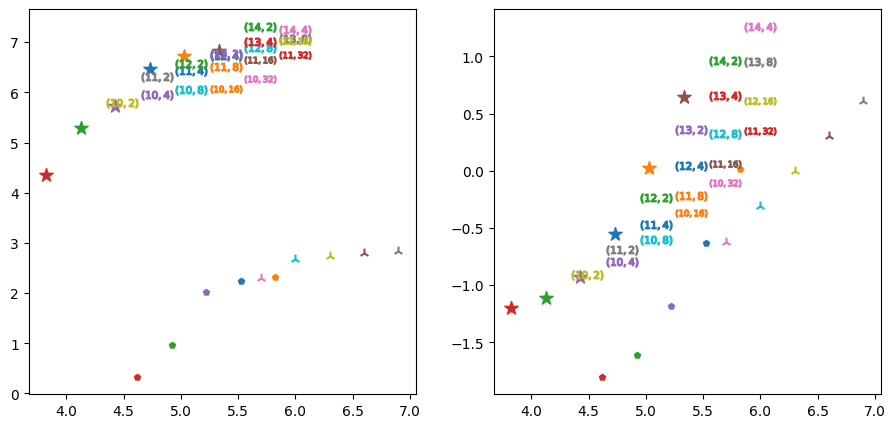

In [70]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
markers = {'SkipRFM': 'p', 'DeepSkip': '2', 'LocalSkip_2_2': '*', 'LocalDeepSkip_2_2': '.'}
s = {'SkipRFM': 20, 'DeepSkip': 50, 'LocalSkip_2_2': 80, 'LocalDeepSkip_2_2': 500}
for i, architecture in enumerate(architectures[config]):
    subfolders = [x for x in glob.glob(f'{folder}/{config}/{architecture}/*') if not 'beta' in x]
    subfolders = [x for x in subfolders if os.path.exists(f'{x}/batch_data.csv')]
    best += [max(summary[architecture].values())]
    for subfolder in subfolders:
        arch = ut.get_arch(subfolder)
        data = pd.read_csv(f'{subfolder}/batch_data.csv')
        vpt = data['tau_f_nmse']
        args = ut.get_arch(subfolder)
        print(args)
        if 'LocalDeepSkip' in architecture:
            if args[3] == 1:
                continue
            label = f'B={args[3]}'
            marker = fr"${(int(np.log2(args[2])), args[3])}$"
            if len(marker) > 9:
            
        else:
            label = None
            marker = markers[architecture]
            
        ax1.scatter(np.log10(arch[-1]), vpt.mean(), marker=marker, s=s[architecture])
        ax2.scatter(np.log10(arch[-1]), np.log10(data['train_time'].mean()), marker=marker, s=s[architecture])
# ax1.legend()

**Generate reconstructed attractor**

In [ ]:
L0, L1, N = 0.4, 3.5, int(1e5)
train = np.load(f"{folder}/train.npy")
train = torch.tensor(train)[:, :N]


# LocalRFM 
arch, D_r, B, G, I = 'LocalRFM_8_1', 15000, 1, 8, 1
save_folder = f"{folder}/{config}/{arch}/D_r-{D_r}_B-{B}"
beta_data = pd.read_csv(f"{folder}/{config}/{arch}/beta/beta_s.csv")
beta = float(beta_data[(beta_data['D_r']==D_r) & (beta_data['B']==1)]['beta'].iloc[0])
drf = localRFM.DeepRF(D_r, B, L0, L1, train, beta, name=arch, save_folder=save_folder, G=G, I=I)
drf.learn(train, 42)
reconstructed_attractor = drf.multistep_forecast(train[:, 0], N)
np.save(f"{save_folder}/attractor.npy", reconstructed_attractor)

# LocalDeepRFM
# arch, D_r, B, G, I = 'LocalDeepSkip_2_2', 1, 2, 8, 1
# save_folder = f"{folder}/{config}/{arch}/D_r-{D_r}_B-{B}"
# beta_data = pd.read_csv(f"{folder}/{config}/{arch}/beta/beta_s.csv")
# beta = float(beta_data[(beta_data['D_r']==D_r) & (beta_data['B']==1)]['beta'].iloc[0])
# drf = localDeepSkip.DeepRF(D_r, B, L0, L1, train, beta, name=arch, save_folder=save_folder, G=G, I=I)
# drf.learn(train, 42)
# reconstructed_attractor = drf.multistep_forecast(train[:, 0], N)
# np.save(f"{save_folder}/attractor.npy", reconstructed_attractor)

**Plot PSD data**

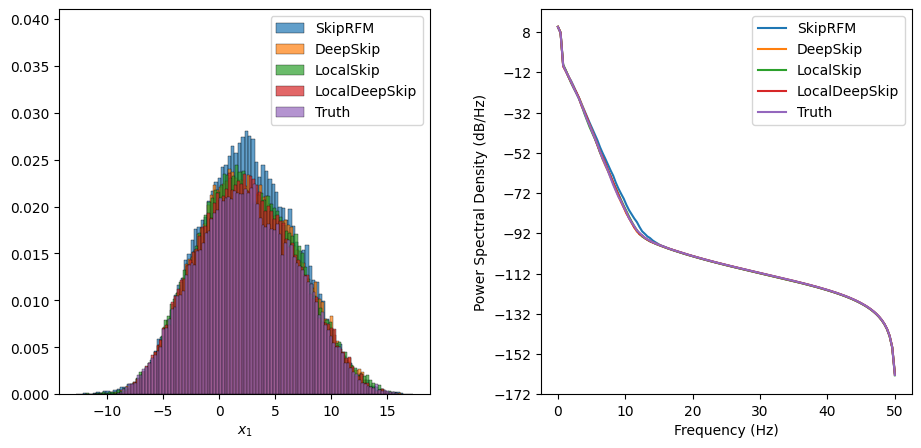

In [29]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
D_r, N = 4096, 100000
folders = [f"{folder}/{config}/SkipRFM/D_r-{D_r}_B-1", f"{folder}/{config}/DeepSkip/D_r-{D_r}_B-2",\
           f"{folder}/{config}/LocalSkip_2_2/D_r-{D_r}_B-1", f"{folder}/{config}/LocalDeepSkip_2_2/D_r-{D_r}_B-2", folder]
for i, data_folder in enumerate(folders):
    filename = "attractor" if i < len(folders)-1 else "train"
    attractor = np.load(f"{data_folder}/{filename}.npy")[:, :N]
    label = "Truth" if i == len(folders)-1 else ut.get_arch(data_folder)[0]
    label = label.split('_')[0]
    # x, y = welch(attractor.mean(axis=0), 100)
    ax2.psd(attractor.mean(axis=0), Fs=100, label=label)
    sns.histplot(attractor[0], ax=ax1, label=label, alpha=0.7, stat="probability", bins=100)
ax1.legend()
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel('')
ax1.set_ylim((0, 0.041))
ax2.legend()
ax2.grid(False)
ax2.set_xlabel('Frequency (Hz)')
fig.subplots_adjust(wspace=0.3)
plt.savefig('../data/plots/L96-climate.pdf', dpi=1200, bbox_inches="tight")

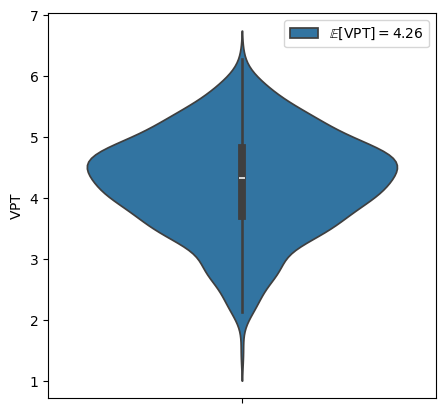

In [23]:
data = pd.read_csv(f'{folder}/{config}/LocalRFM_8_1/D_r-{15000}_B-{1}/batch_data.csv')
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
sns.violinplot(data['tau_f_nmse'], ax=ax, label = r'$\mathbb{E}[{\rm VPT}]=$' + f"{data['tau_f_nmse'].mean():.2f}")
ax.set_ylabel(r'${\rm VPT}$')
ax.legend()
plt.savefig('../data/plots/KS-200-D_r-15000.png', bbox_inches="tight", dpi=1200)

500

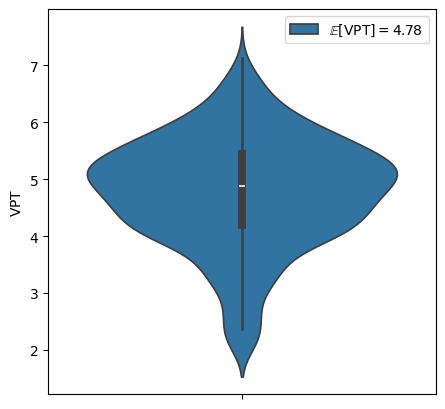

In [142]:
config, D_r, B = 'config_1', 14000, 2
data = pd.read_csv(f'{folder}/{config}/LocalDeepRFM_8_1/D_r-{D_r}_B-{B}/batch_data.csv')
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
sns.violinplot(data['tau_f_nmse'], ax=ax, label = r'$\mathbb{E}[{\rm VPT}]=$' + f"{data['tau_f_nmse'].mean():.2f}")
ax.set_ylabel(r'${\rm VPT}$')
ax.legend()
len(data)

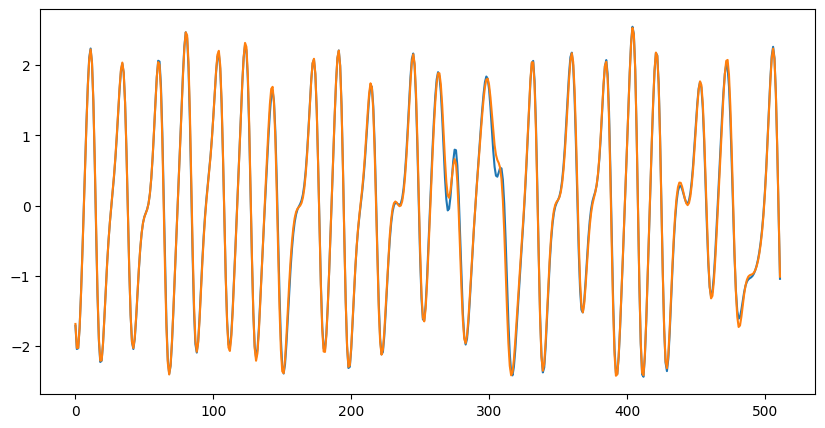

In [4]:
l = 200
u = np.load(f'../data/KS-{l}/train.npy')
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
# ax.plot(u[250:350, 1000])
# ax.plot(u[250:350, 1001])
ax.plot(u[:, 1000])
ax.plot(u[:, 1001])

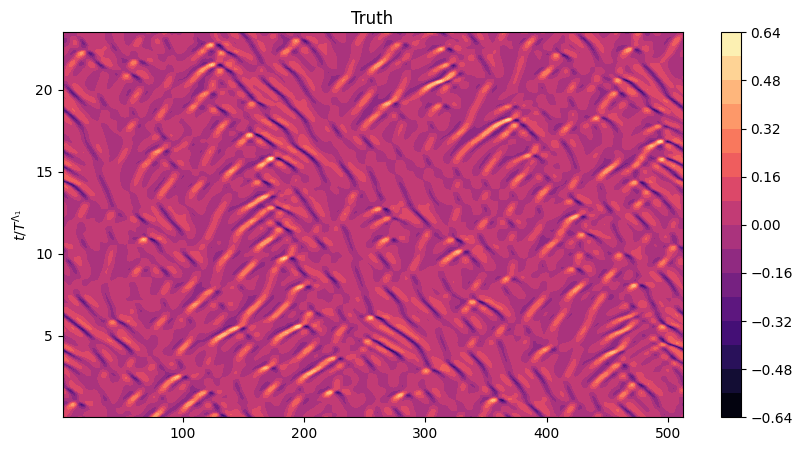

In [147]:
ut.waterfall(u[:, 1:1001]-u[:, :1000], **kwargs[l])

In [8]:
summary = ut.summary(dynamical_system)['config_1']
ut.latexify(summary)

['LocalRFM_8_1', 'LocalDeepRFM_4_2', 'LocalDeepRFM_8_1', 'LocalDeepSkip_8_1', 'LocalRFMN_8_1', 'LocalSkipN_8_1', 'LocalDeepRFMN_8_1', 'LocalDeepSkipN_8_1']

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|} \hline
\multicolumn{4}{|c|}{Model} &\multicolumn{5}{c|}{VPT} & \multicolumn{2}{c|}{}\\ \hline
architecture & $D_r$ & $B$ & model size & mean & std & median & min & max &$\beta$ & $\mathbb{E}[t_{\rm train}]$(s)\\ \hline\hline
\multirow{2}{*}{LocalRFM$_{8,1}$} & 8192 & 1 & 270336 & 3.6 & 1.3 & 3.9 & 0.5 & 6.5 & 8.56e-06 & 1.2e+00\\ \cline{2-11}
 & \cellcolor{pink} 15000 & \cellcolor{pink} 1 & \cellcolor{pink} 495000 & \cellcolor{pink} 4.3 & \cellcolor{pink} 0.8 & \cellcolor{pink} 4.3 & \cellcolor{pink} 1.5 & \cellcolor{pink} 6.3 & \cellcolor{pink} 2.80e-05 & \cellcolor{pink} 4.1e+00\\ \cline{2-11}
\hline\hline
\multirow{6}{*}{LocalDeepRFM$_{8,1}$} & 8192 & 2 & 671744 & 4.0 & 1.3 & 4.2 & 0.5 & 6.8 & 4.60e-06 & 2.1e+00\\ \cline{2-11}
 & 8192 & 3 & 1007616 & 4.5 & 1.0 & 4.6 & 1.0 & 7.1 & 3.52e-05

In [2]:
for a, b, c in ut.get_best_models(dynamical_system, 'config_1'):
    print(a, b, c)

LocalDeepSkipN_8_1 (15000, 2, 8, 1) [5.041173, 0.8519007555846698, 5.1465, 2.6085, 7.708, 2e-05, 7.909782587051391, 1230000]
LocalDeepRFM_8_1 (14000, 2, 8, 1) [4.782908, 0.9690066937235068, 4.87625, 2.0915, 7.1205, 2e-05, 6.504697515940001, 1148000]
LocalDeepRFMN_8_1 (15000, 2, 8, 1) [4.986465, 0.9162137373451678, 5.04075, 2.6555, 7.614, 2e-05, 7.560776042313999, 1230000]
LocalRFM_8_1 (15000, 1, 8, 1) [4.259422000000001, 0.8151536314104252, 4.324, 1.4805, 6.2745, 2.8e-05, 4.093467444896698, 495000]
LocalDeepSkip_8_1 (15000, 2, 8, 1) [0.546751, 0.05853175575586066, 0.5405, 0.3995, 0.799, 2e-05, 7.85274590532, 1230000]


In [9]:
summary['LocalSkipN_8_1']

{(15000, 1, 8, 1): [4.2958,
  0.8441757497066505,
  4.40625,
  2.0445,
  6.3685,
  4.240000000000001e-05,
  3.7782645416259766,
  495000]}

In [3]:
len(p)

2

In [7]:
ut.get_arch('../data/KS-200/config_1/LocalSkipN_8_1/D_r-15000_B-1')

['LocalSkipN_8_1', 512, 15000, 1, 8, 1, 495000]

In [5]:
23.8/np.sqrt(40)

3.763110415600371